In [28]:
from os import listdir
from sys import argv

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, accuracy_score

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, "/mnt/Dados/Documentos/xgboost/python-package/")
import xgboost as xgb

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale, StandardScaler, minmax_scale

from sklearn.svm import SVC

import time

from sklearn.externals import joblib
import pandas as pd
from sklearn.manifold import Isomap, TSNE
from sklearn.model_selection import GroupKFold, LeavePGroupsOut, LeaveOneGroupOut

def shuffled(array):
    x = array.values.copy()
    np.random.shuffle(x)
    return x

def shuffled2(array):
    x = array.copy()
    np.random.shuffle(x)
    return x

import pyperclip

In [2]:
# Read database from disk
data = pd.read_csv("datasetfull.csv")

In [3]:
# Shuffle data
data = data.loc[shuffled(data.index)]

In [4]:
# Copy not-feature data from the base, before removing them for training purpose

y = data["GT"]
IMG = data["IMG"]
BLOCK = data["BLOCK"]
solo = data["solo"]
base = data["base"]

In [15]:
# Remove not-feature data from the base, for training purpose

del data["GT"]
del data["IMG"] # big jump in precision by keeping this feature
del data["BLOCK"]
del data["solo"]
del data["base"]

# 0)  AUC and Mean Acc. Analysis of everything

In [38]:
def getBestTreshold(FPR, TPR, TH):
    """This function is for calculating the Mean Accuracy, given a ROC curve"""
    i_max = max(range(len(TPR)), key = lambda x : TPR[x] + 1 - FPR[x])
    mean_accuracy = (TPR[i_max] + 1 - FPR[i_max])/2
    return mean_accuracy, TH[i_max]

In [36]:
def getPerformance(true, prediction):
    auc = roc_auc_score(true, prediction)        
    fpr, tpr, th = roc_curve(true, prediction)
    if auc < .5:
        fpr, tpr = tpr, fpr
        auc = 1 - auc
    mean_acc, bestTH = getBestTreshold(fpr, tpr, th)
    return auc, mean_acc, bestTH, fpr, tpr

In [6]:
def splitByImages(data, test_size, repetitions):
    images = list(set(IMG.loc[data.index]))
    n = len(images)
    for _ in range(repetitions):
        np.random.shuffle(images)
        split_point = int(n * (1-test_size))
        yield images[:split_point], images[split_point:]

In [8]:
def XGBTrain(data, train_imgs, val_imgs, y):

    X_train, y_train = data.loc[IMG.isin(train_imgs)], y.loc[IMG.isin(train_imgs)]
    X_val, y_val = data.loc[IMG.isin(val_imgs)], y.loc[IMG.isin(val_imgs)]
    
    ratio = float(np.sum(y_train == 1)) / np.sum(y_train==0)

    clf = xgb.XGBClassifier(
                    max_depth = 4,
                    n_estimators=1000,
                    learning_rate=0.2, 
                    nthread=3,
                    subsample=1.0,
                    colsample_bytree=1,
                    scale_pos_weight = ratio,
                    reg_alpha=0.03,
                    seed=1301)

    clf.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
            eval_set=[(X_val, y_val)], verbose = False)
    
    return clf

In [10]:
LessCompact = [0]
MoreCompact = [1]
Calibrated = [0, 1]
NotCalibrated = [2]
experiments = [[LessCompact, MoreCompact], [MoreCompact, LessCompact],
              [Calibrated, NotCalibrated], [NotCalibrated, Calibrated]]


solo: 0


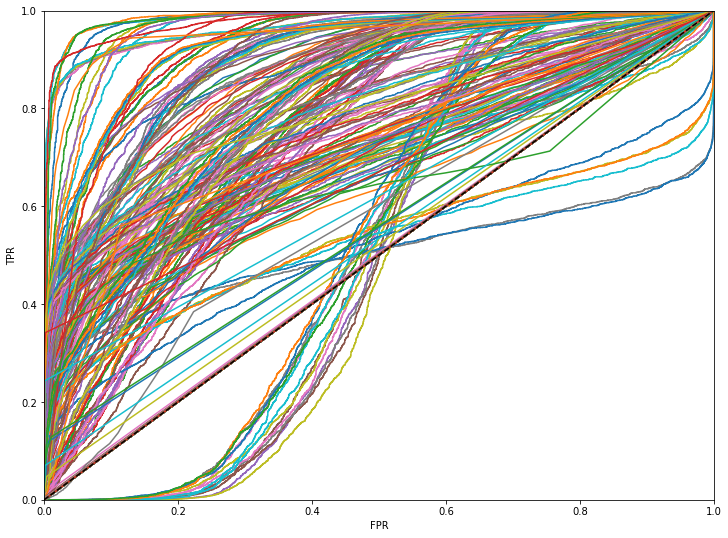


solo: 1


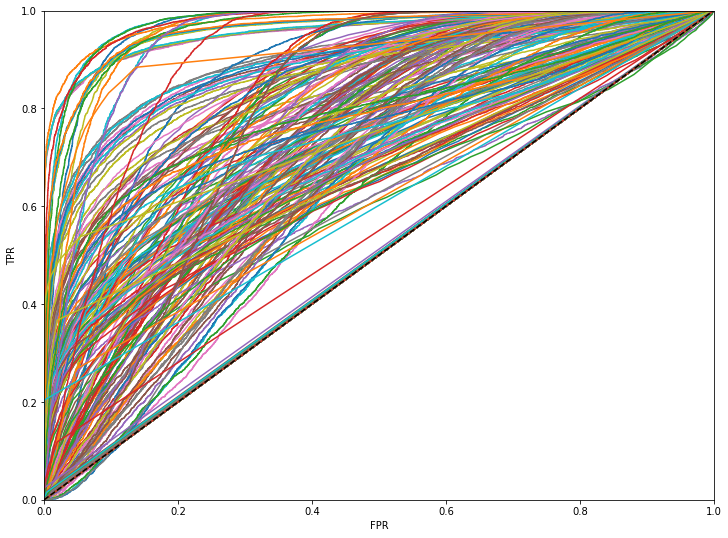


solo: 2


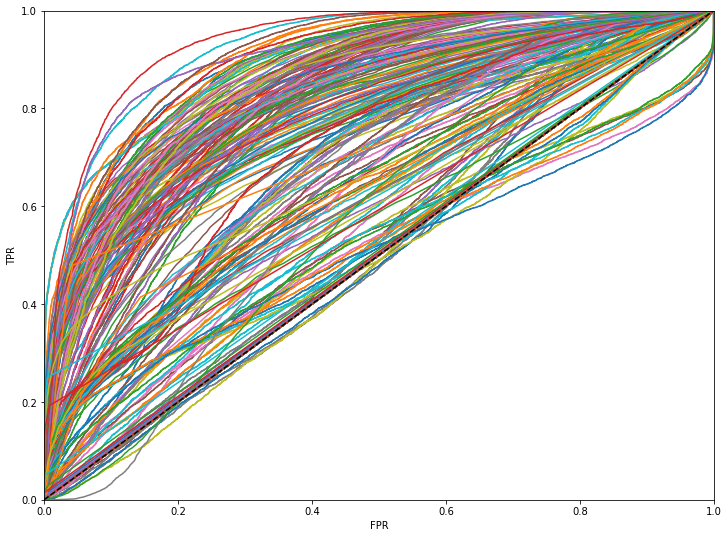

In [130]:
# Plot ROC curves for each soil for all columns
# and save AUC and MAc for each soil for all columns in two separate dataframes

scores_auc = pd.DataFrame(None, columns = [0, 1, 2], index=data.columns)
scores_mac = pd.DataFrame(None, columns = [0, 1, 2], index=data.columns)
for soil in range(3):
    plt.figure(figsize=(12,9))
    print("\nsolo:", soil)
    
    for col in data.columns:
        score = roc_auc_score(y.loc[solo == soil], data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
        mean_acc, _ = getBestTreshold(fpr, tpr, th)

        scores_auc.loc[col, soil] = score
        scores_mac.loc[col, soil] = mean_acc

        #print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr)

    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.show()


In [132]:
scores_mac["amean"] = scores_mac[[0,1,2]].mean(axis=1)
scores_mac["min"] = scores_mac[[0,1,2]].min(axis=1)
#scores_mac["gmean"] = np.power(scores_mac[[0,1,2]].prod(axis=1) , 1/3)

In [149]:
best_features = scores_mac.sort_values("min", ascending=False)[[0,1,2]].iloc[:10]
pyperclip.copy(best_features.to_latex())
best_features

,0,1,2
NGRDI_max,0.869164,0.851407,0.86316
NGRDI_mean,0.909028,0.885891,0.842153
ExGR_max,0.900093,0.884735,0.839155
ExGR_mean,0.937881,0.909558,0.812371
VEG_max,0.911753,0.897611,0.807138
CIVE_min,0.915962,0.900116,0.800298
CIVE_q25,0.918479,0.900932,0.798601
CIVE_q50,0.919052,0.901032,0.797287
ExG_max,0.917517,0.900744,0.797083
CIVE_q75,0.920947,0.901448,0.796452


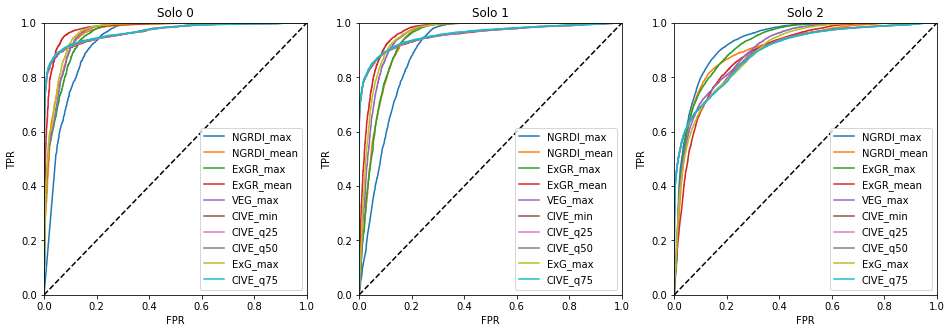

In [148]:
cols = scores_mac.sort_values("min", ascending=False)[[0,1,2]].iloc[:10].index
plt.figure(figsize=(16,5))
for soil in range(3):
    plt.subplot(1,3,soil+1)
    
    for col in cols:
        score = roc_auc_score(y.loc[solo == soil], data.loc[solo == soil][col])
        fpr, tpr, th = roc_curve(y.loc[solo == soil], data.loc[solo == soil][col])
        if score < .5:
            fpr, tpr = tpr, fpr
            score = 1 - score
            
        #print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
        plt.plot(fpr, tpr, label = col)
    plt.title("Solo %d" % soil)
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.plot([0,1], [0,1], "k--")
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.legend(loc = 4)
plt.savefig("report1/figures/10bestminfeatures.png")

In [141]:
scores_mac.sort_values(2, ascending=False)[2].iloc[:10]

NGRDI_max      0.86316
NGRDI_mean    0.842153
ExGR_max      0.839155
NGRDI_std     0.824134
ExGR_std      0.823302
VEG_std       0.813944
ExGR_mean     0.812371
VEG_max       0.807138
CIVE_std      0.804727
ExG_std       0.801579
Name: 2, dtype: object

# 1) Check VI discriminant capability

### In this section, we check the AUC, Mean Accuracy and ROC curves for each VI in each soil type (0, 1, 2)

In [23]:
names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI"]

In [26]:
VI_cols = [name + "_mean" for name in names_VI]

In [24]:
# Get only columns with mean of VI values of 16x16 regions
VI_data = data[[name + "_mean" for name in names_VI]]

In [ ]:
"""
for each generalization test:
    separate into test and rest (how many times?)
    separate rest into train and val (how many times?)
    find best th value and best VI (which mean: keep the VI used and the TH.
        > maybe save all in a table and then order it
    test the best
"""

In [47]:
mac_matrix = np.zeros((4, reps))
VI_scores = [{name + "_mean" : None for name in names_VI}] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    
    
    for col in VI_cols:
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        prediction = Xleft[col]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[solo.isin(left)], prediction)

        
        # get test performance
        prediction = Xtest[col]
        mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        if col == "CIVE_mean":
            mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction < bestTH))
        
               
        # save performance
        VI_scores[e][col] = mean_acc
        
        print(" > %s \t Val vs Test (MAc) = %.3f vs %.3f" % (col, val_mean_acc, mean_acc))
        
print("Done.")    

Experiment [0] [1]
 > ExG_mean 	 Val vs Test (MAc) = 0.951 vs 0.870
 > ExGR_mean 	 Val vs Test (MAc) = 0.938 vs 0.909
 > CIVE_mean 	 Val vs Test (MAc) = 0.951 vs 0.884
 > VEG_mean 	 Val vs Test (MAc) = 0.951 vs 0.889
 > WI_mean 	 Val vs Test (MAc) = 0.937 vs 0.689
 > NGRDI_mean 	 Val vs Test (MAc) = 0.909 vs 0.907
Experiment [1] [0]
 > ExG_mean 	 Val vs Test (MAc) = 0.922 vs 0.962
 > ExGR_mean 	 Val vs Test (MAc) = 0.910 vs 0.955
 > CIVE_mean 	 Val vs Test (MAc) = 0.921 vs 0.963
 > VEG_mean 	 Val vs Test (MAc) = 0.921 vs 0.964
 > WI_mean 	 Val vs Test (MAc) = 0.917 vs 0.947
 > NGRDI_mean 	 Val vs Test (MAc) = 0.886 vs 0.927
Experiment [0, 1] [2]
 > ExG_mean 	 Val vs Test (MAc) = 0.935 vs 0.733
 > ExGR_mean 	 Val vs Test (MAc) = 0.922 vs 0.806
 > CIVE_mean 	 Val vs Test (MAc) = 0.935 vs 0.738
 > VEG_mean 	 Val vs Test (MAc) = 0.935 vs 0.748
 > WI_mean 	 Val vs Test (MAc) = 0.912 vs 0.690
 > NGRDI_mean 	 Val vs Test (MAc) = 0.890 vs 0.853
Experiment [2] [0, 1]
 > ExG_mean 	 Val vs Test (

In [39]:
reps = 5
auc_matrix = np.zeros((4, reps))
mac_matrix = np.zeros((4, reps))
auc_matrix_val = np.zeros((4, reps))
clfs = [[None] * n_reps] * 4 # 4 is the number of experiments

for e, (left, test) in enumerate(experiments):
    print("Experiment", left, test)
    Xleft = data.loc[solo.isin(left)]
    Xtest = data.loc[solo.isin(test)]
    
    
    for i, (train_imgs, val_imgs) in enumerate(splitByImages(Xleft, 1/4, n_reps)):
        # train
        clf = XGBTrain(data, train_imgs, val_imgs, y)
        
        # get val performance of this trained model: ROC, AUC and MAc, and also the best threshold value for test
        prediction = clf.predict_proba(data.loc[IMG.isin(val_imgs)])[:,-1]
        val_auc, val_mean_acc, bestTH, fpr, tpr = getPerformance(y.loc[IMG.isin(val_imgs)], prediction)
        
        # get train either?
        
        # get test performance
        prediction = clf.predict_proba(data.loc[solo.isin(test)])[:,-1]
        mean_acc = accuracy_score(y.loc[solo.isin(test)], 1 * (prediction > bestTH)) # 1 * array = array.astype(int)
        
               
        # save performance
        mac_matrix[e, i] = mean_acc
        auc_matrix_val[e, i] = clf.best_score
        
        # save classifiers for further analysis
        clfs[e][i] = clfs
        
        print(" > %d iterations \t Val vs Test (MAc) = %.3f vs %.3f" % (clf.best_iteration, 
                                                                               val_mean_acc, mean_acc))
        
print("Done.")    

Experiment [0] [1]
 > 42 iterations 	 Val vs Test (MAc) = 0.906 vs 0.834
 > 86 iterations 	 Val vs Test (MAc) = 0.968 vs 0.830
 > 16 iterations 	 Val vs Test (MAc) = 0.938 vs 0.782
 > 94 iterations 	 Val vs Test (MAc) = 0.944 vs 0.752
 > 16 iterations 	 Val vs Test (MAc) = 0.951 vs 0.876
Experiment [1] [0]
 > 28 iterations 	 Val vs Test (MAc) = 0.895 vs 0.827
 > 41 iterations 	 Val vs Test (MAc) = 0.913 vs 0.910
 > 31 iterations 	 Val vs Test (MAc) = 0.928 vs 0.942
 > 43 iterations 	 Val vs Test (MAc) = 0.925 vs 0.944
 > 29 iterations 	 Val vs Test (MAc) = 0.944 vs 0.938
Experiment [0, 1] [2]
 > 33 iterations 	 Val vs Test (MAc) = 0.934 vs 0.725
 > 37 iterations 	 Val vs Test (MAc) = 0.954 vs 0.727
 > 48 iterations 	 Val vs Test (MAc) = 0.956 vs 0.725
 > 33 iterations 	 Val vs Test (MAc) = 0.935 vs 0.724
 > 77 iterations 	 Val vs Test (MAc) = 0.945 vs 0.723
Experiment [2] [0, 1]
 > 60 iterations 	 Val vs Test (MAc) = 0.900 vs 0.924
 > 59 iterations 	 Val vs Test (MAc) = 0.959 vs 0.910


# Análise do Resultados

In [87]:
clf_ind = 2 # base 2 out is better to find out why training in 0 and 1 fail in generalizing to 2
clf = clfs[clf_ind][0]

train_index, test_index = splits[clf_ind]
X_train, y_train = data.iloc[train_index], y.iloc[train_index]
X_test, y_test = data.iloc[test_index], y.iloc[test_index]

predict = clf.predict_proba(X_test, ntree_limit=clf.best_iteration)[:,-1]

 > NGRDI_max                      AUC = 0.934 	 MeanAcc = 0.863
 > NGRDI_mean                     AUC = 0.907 	 MeanAcc = 0.842
 > ExGR_max                       AUC = 0.923 	 MeanAcc = 0.839
 > NGRDI_std                      AUC = 0.910 	 MeanAcc = 0.824
 > ExGR_std                       AUC = 0.905 	 MeanAcc = 0.823
 > VEG_std                        AUC = 0.897 	 MeanAcc = 0.814
 > ExGR_mean                      AUC = 0.891 	 MeanAcc = 0.812
 > VEG_max                        AUC = 0.904 	 MeanAcc = 0.807
 > CIVE_std                       AUC = 0.888 	 MeanAcc = 0.805
 > ExG_std                        AUC = 0.885 	 MeanAcc = 0.802
 > predict                        AUC = 0.854 	 MeanAcc = 0.805


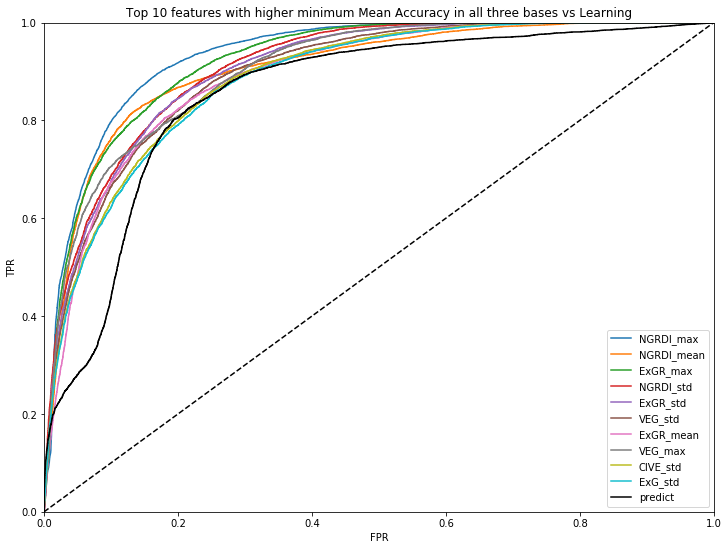

In [162]:
plt.figure(figsize=(12,9))
for col in scores_mac[2].sort_values(ascending=False).index[:10]:
    score = roc_auc_score(y.loc[solo==2], data.loc[solo==2][col])
    fpr, tpr, th = roc_curve(y.loc[solo==2], data.loc[solo==2][col])
    if score < .5:
        fpr, tpr = tpr, fpr
        score = 1 - score
    mean_acc, _ = getBestTreshold(fpr, tpr, th)
    print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
    plt.plot(fpr, tpr, label = col)

score = roc_auc_score(y_test, predict)   
FPR, TPR, TH = roc_curve(y_test, predict)
mean_acc, _ = getBestTreshold(FPR, TPR, TH)
print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % ("predict", score, mean_acc))
plt.plot(FPR,TPR, "k-", label = "predict", lw = 1.5)

plt.title("Top 10 features with higher minimum Mean Accuracy in all three bases vs Learning")
plt.ylim((0,1))
plt.xlim((0,1))
plt.plot([0,1], [0,1], "k--")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend();
plt.savefig("report1/figures/prediction_vs_bestFeatures.png")

 > WI_correlation_3*np.pi/2       AUC = 0.648 	 MeanAcc = 0.601
 > WI_mean                        AUC = 0.711 	 MeanAcc = 0.670
 > NGRDI_max                      AUC = 0.934 	 MeanAcc = 0.863
 > NGRDI_interior_25              AUC = 0.640 	 MeanAcc = 0.635
 > NGRDI_mean                     AUC = 0.907 	 MeanAcc = 0.842
 > WI_max                         AUC = 0.811 	 MeanAcc = 0.735
 > NGRDI_interior_21              AUC = 0.562 	 MeanAcc = 0.584
 > WI_std                         AUC = 0.808 	 MeanAcc = 0.720
 > WI_min                         AUC = 0.523 	 MeanAcc = 0.570
 > WI_correlation_np.pi/4         AUC = 0.599 	 MeanAcc = 0.568
 > predict                        AUC = 0.854 	 MeanAcc = 0.805


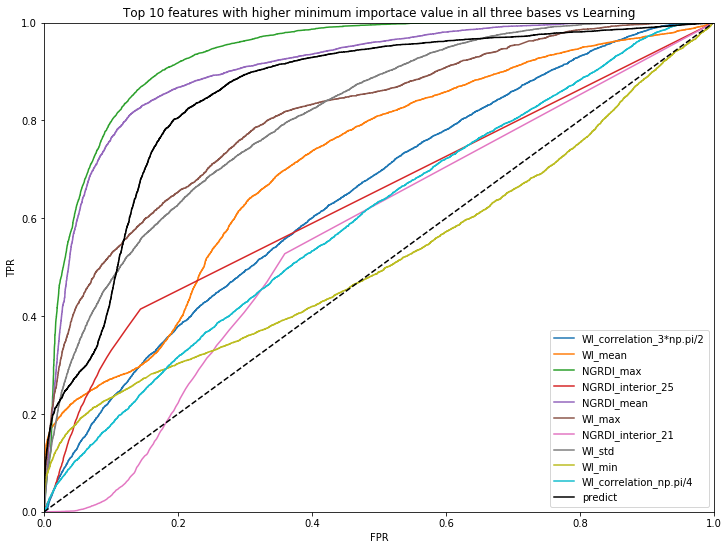

In [164]:
plt.figure(figsize=(12,9))
for col in importance_single[2].sort_values(ascending=False)[:10].index:
    score = roc_auc_score(y.loc[solo==2], data.loc[solo==2][col])
    fpr, tpr, th = roc_curve(y.loc[solo==2], data.loc[solo==2][col])
    if score < .5:
        fpr, tpr = tpr, fpr
        score = 1 - score
    mean_acc, _ = getBestTreshold(fpr, tpr, th)
    print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % (col, score, mean_acc))
    plt.plot(fpr, tpr, label = col)

score = roc_auc_score(y_test, predict)   
FPR, TPR, TH = roc_curve(y_test, predict)
mean_acc, _ = getBestTreshold(FPR, TPR, TH)
print(" > %-30s AUC = %.3f \t MeanAcc = %.3f" % ("predict", score, mean_acc))
plt.plot(FPR,TPR, "k-", label = "predict", lw = 1.5)

plt.title("Top 10 features with higher minimum importace value in all three bases vs Learning")
plt.ylim((0,1))
plt.xlim((0,1))
plt.plot([0,1], [0,1], "k--")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.savefig("report1/figures/10bestminGAIN_vs_predict")

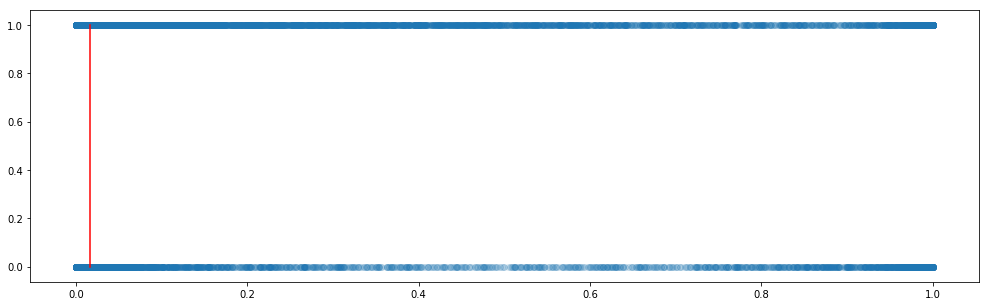

In [91]:
plt.figure(figsize=(17,5))
plt.scatter(predict, y_test, alpha = .1)
th = TH[th_ix]
plt.plot([th, th], [1,0], "r-")

In [92]:
train_pred = clf.predict_proba(data, ntree_limit=clf.best_iteration)[:,-1]

In [93]:
m1 = ((y == 1) & (train_pred < th))
m0 = ((y == 0) & (train_pred > th))
m1.sum(), m0.sum()

(1336, 6293)

In [94]:
dec = PCA()

In [95]:
pca = dec.fit_transform(StandardScaler().fit_transform(data.fillna(10**-5)))

<BarContainer object of 30 artists>

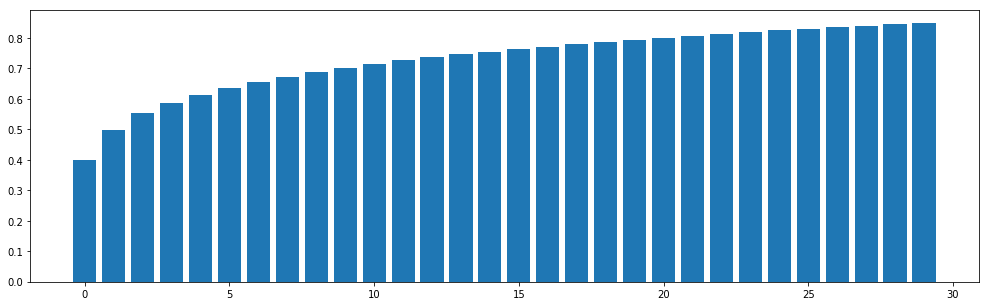

In [96]:
plt.figure(figsize=(17,5))
xvr = dec.explained_variance_ratio_[:30]
plt.bar(range(len(xvr)), np.cumsum(xvr))

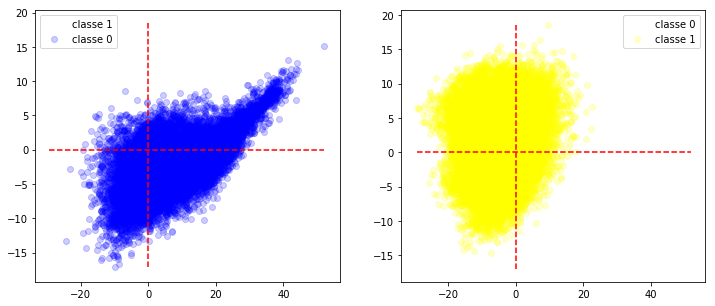

In [97]:
plt.figure(figsize=(12,5))
for c in {0,1}:
    plt.subplot(1,2,c+1)
    plt.scatter(pca[y==(1-c),0], pca[y==(1-c),1], alpha = 0 * .2, label = "classe %d" % (1-c))
    plt.scatter(pca[y==c,0], pca[y==c,1], alpha = .2, label = "classe %d" % c, color = "blue" if c == 0 else "yellow")
    plt.plot([0,0], [pca[:,1].min(), pca[:,1].max()], "r--")
    plt.plot([pca[:,0].min(), pca[:,0].max()], [0,0], "r--")
    plt.legend()

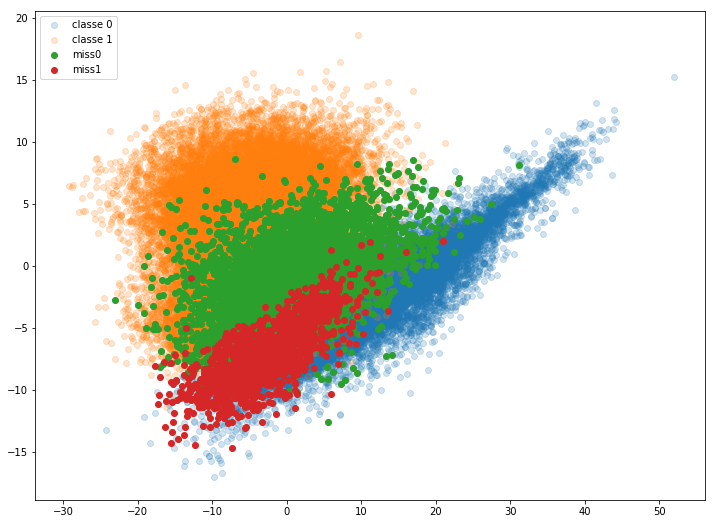

In [98]:
plt.figure(figsize=(12,9))
for c in {0,1}:
    plt.scatter(pca[y==c,0], pca[y==c,1], alpha = .2, label = "classe %d" % c)
plt.scatter(pca[m0,0], pca[m0,1], label = "miss0")
plt.scatter(pca[m1,0], pca[m1,1], label = "miss1")
plt.legend()

In [99]:
from skimage.util.shape import view_as_blocks
from skimage.io import imread


In [115]:
paths = ["imgs_orig", "gts_orig"] # TROCAR AQUI DEPENDENDO DA BASE

path_imgs = sorted([ paths[0] + '/' + i for i in listdir(paths[0]) ])
path_gts = sorted([ paths[1] + '/' + i for i in listdir(paths[1]) ])


paths2 = ["imgs", "gts"] # TROCAR AQUI DEPENDENDO DA BASE

path_imgs2 = sorted([ paths2[0] + '/' + i for i in listdir(paths2[0]) ])
path_gts2 = sorted([ paths2[1] + '/' + i for i in listdir(paths2[1]) ])

In [116]:
misses = pd.concat([IMG[m0].value_counts().rename("NOVEG-miss"), IMG[m1].value_counts().rename("VEG-miss")], axis = 1).fillna(0)

In [117]:
misses["sum"] = misses["NOVEG-miss"] + misses["VEG-miss"]

In [118]:
misses.sort_values("sum",ascending=False)

,NOVEG-miss,VEG-miss,sum
50,711,0.0,711.0
52,1,545.0,546.0
59,20,427.0,447.0
57,378,0.0,378.0
48,366,0.0,366.0
49,364,1.0,365.0
40,278,0.0,278.0
46,252,1.0,253.0
41,228,1.0,229.0
60,3,224.0,227.0


In [119]:
def highlight(ind, color):
    x_ini = (ind % 32) * 16
    x_end = x_ini + 15
    y_ini = (ind // 32) * 16
    y_end = y_ini + 15
    plt.fill_between([x_ini, x_end], y_ini, y_end, alpha =.4, color = color)

In [181]:
i = 41
if i >= 40:
    img = imread(path_imgs2[i-40])
    gt = imread(path_gts2[i-40], as_grey=True)
else:
    img = imread(path_imgs[i])
    gt = imread(path_gts[i], as_grey=True)


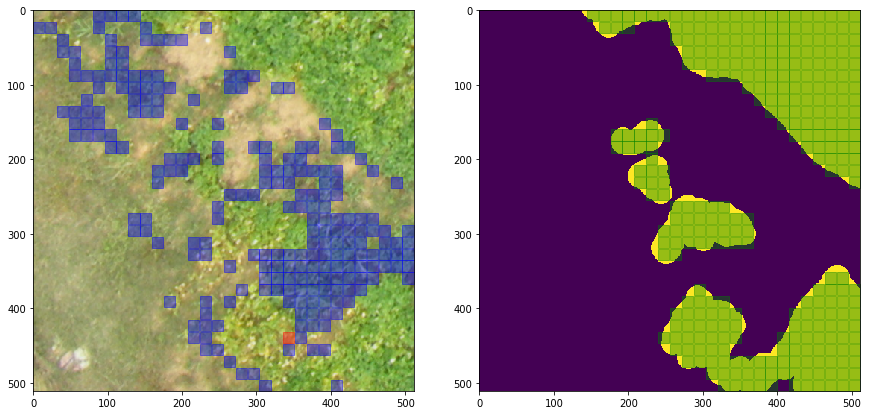

In [182]:
plt.figure(figsize=(16,7))
plt.subplots_adjust(wspace = 0, hspace = 0)

plt.subplot(1,2,1)
plt.imshow(img)
for b in BLOCK[(IMG == i) & m1]:
    highlight(b, "red")
for b in BLOCK[(IMG == i) & m0]:
    highlight(b, "blue")
plt.ylim((511,0))
plt.xlim((0,511))

plt.subplot(1,2,2)
plt.imshow(gt)
for b in BLOCK[(IMG == i) & (y == 1)]:
    highlight(b, "green")
plt.ylim((511,0))
plt.xlim((0,511))

plt.savefig("report1/figures/errovisu%02d.png" % i)